# Reinforcement Learning (RL Solution)

# Windy GridWorld Problem (SARSA and Q-Learning Approaches used)

#### We are considering the "Windy Grid World" setting here as in the Sutton and Barto Book. 
#### We will consider the same setting of (0-0-0-1-1-1-2-2-1-0).

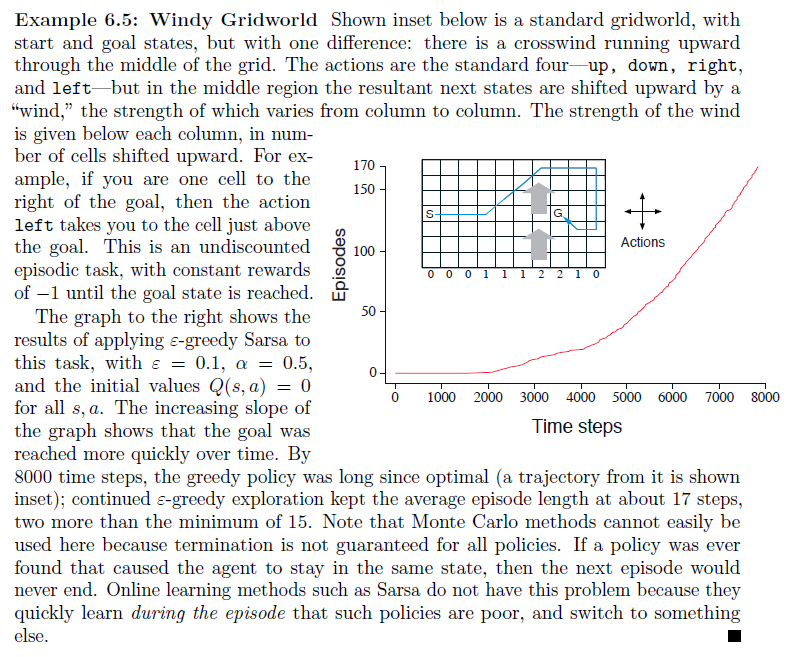

In [1]:
from IPython.display import Image
Image("../input/windygridworld/Ex6.5_WindyGridWorld.png")

* Apply SARSA algorithm with below considerations:
    * a) Epsilon = 0.1, Alpha = 0.5
    * b) Epsilon = 0.2, Alpha = 0.1
    * c) Epsilon = 0.05, Alpha = 0.2

* Apply Q-Learning algorithm with below considerations:
    * a) Epsilon = 0.1, Alpha = 0.5
    * b) Epsilon = 0.2, Alpha = 0.1
    * c) Epsilon = 0.05, Alpha = 0.2

We will have to run above experiments for 300 episodes and plot charts. (Episodes vs No of time steps)

* We also need to report the minimum length episode that each algorithm is able to learn.

# 1. Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pylab as pl
import matplotlib.pyplot as plt 
import time # We will use this to time our experiments for various observations

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# 2. Define GridWorld Class

#### Let us define the gridWorld class with settings that are considered.

In [11]:
class gridWorld(object):
    
    def __init__(self):
        super(gridWorld, self).__init__()
        self.start = 0
        self.goal = 0
        # Provide the setting of gridWorld rows and columns
        self.row = 7
        self.col = 10
        self.x_max = self.col - 1
        self.y_max = self.row - 1
        # Declare windy columns and their effect
        self.wind_1 = [3, 4, 5, 8]
        self.wind_2 = [6, 7]
        # Provide action list : Up/Down/Left/Right
        self.actions_list = ['N', 'E', 'S', 'W']
        
    def cell(self,pos):
        return pos[1] + self.col * pos[0]
    
    def setTerminal(self, startState, goalState):
        # startState and goalState are tuples
        self.start = self.cell(startState)
        self.goal = self.cell(goalState)
        
    def nextState(self, state, action):
        # The "state" parameter is an integer that represents position in grid
        x = state % self.col
        y = (state - x) / self.col
        # Now let's define and interpret actions
        del_x = 0
        del_y = 0
        if action == 'E':
            del_x = 1
        elif action == 'W':
            del_x = -1
        elif action == 'N':
            del_y = -1
        elif action == 'S':
            del_y = 1
        else:
            raise('Invalid action! Actions taken must be in: ',self.actions_list)
        # Now move to new position
        new_x = max(0, min(x + del_x, self.x_max))
        new_y = max(0, min(y + del_y, self.y_max))
        # When wind blows to a new state
        if new_x in self.wind_1:
            new_y = max(0, new_y - 1)
        if new_x in self.wind_2:
            new_y = max(0, new_y - 2)
        # now let's return these new state values
        return self.cell((new_y,new_x))
    
    def checkTerminal(self, state):
        return state == self.goal
    
    def rewardFunction(self, state_prime):
        # When it reaches goal state then reward is 0 else all actions should yield -1
        if state_prime == self.goal:
            return 0
        else:
            return -1
        
def trajectoryPath(world, traj):
    # Initialize gridworld
    world_map = np.zeros((world.row, world.col))
    for i,state in enumerate(traj):
        x = int(state % world.col)
        y = int((state - x) / world.col)
        world_map[y, x] = i + 1
    print(world_map)
    print("\n")

# 3. SARSA Algorithm

#### Let us consider SARSA algorithm. We have considered 300 episodes.

In [12]:
def gridWorld_SARSA(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0
    
    # function for greedy action
    def epsGreedy(episode, q_dict):
        def greedyAct(_q_dict):
            greedy_act = ''
            max_q = -1e10
            for act in world.actions_list:
                if _q_dict[act] > max_q:
                    greedy_act = act
                    max_q = _q_dict[act]
            return greedy_act
        
        m = len(world.actions_list)
        greedy_act = greedyAct(q_dict)
        p = []
        for act in world.actions_list:
            if act == greedy_act:
                p.append((epsilon * 1. / m) + 1 - epsilon)
            else:
                p.append(epsilon * 1. / m)
        choice = np.random.choice(world.actions_list,size = 1, p = p)
        return choice[0]
    
    ep = 1 # Episode number
    ep_max = 300 # number of max episodes
    step_ep_list = []
    step = 0
    while ep < ep_max:
        #print("Episode: ", ep)
        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        # Choose action from state
        act = epsGreedy(ep, q_table[state])
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime])
            q_table[state][act] += alpha * (reward + gamma * q_table[state_prime][act_prime] - q_table[state][act])
            state = state_prime
            act = act_prime
            # Increase Step Counter
            step += 1
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            # Update the trajectory
            trajectory.append(state)
        
        if ep == (ep_max - 1):
            trajectoryPath(world, trajectory)
        # Increase the episode counter
        ep += 1
    
    start_time = time.time()
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

Now we will execute SARSA algorithm with different combinations of ∈ and α.

We will plot the chart for Number of Episodes vs Number of Steps taken for 3 combinations.

* ∈=0.1,α=0.5
* ∈=0.2,α=0.1
* ∈=0.05,α=0.2

We will also see the path taken from steps perspective to reach from START state to GOAL state.

# 3.1 Experiment Observations for SARSA, ∈=0.1,α=0.5

Plot for Option: ∈=0.1,α=0.5 

[[ 0.  0.  0.  0.  0.  0. 10. 11. 12. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  9.  0.  0.  0. 15.]
 [ 2.  0.  0.  0.  8.  0.  0. 21.  0. 16.]
 [ 3.  4.  5.  7.  0.  0.  0.  0.  0. 17.]
 [ 0.  0.  6.  0.  0.  0.  0.  0. 20. 18.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 19.]]


Time elapsed is (in Secs):  0.008787870407104492


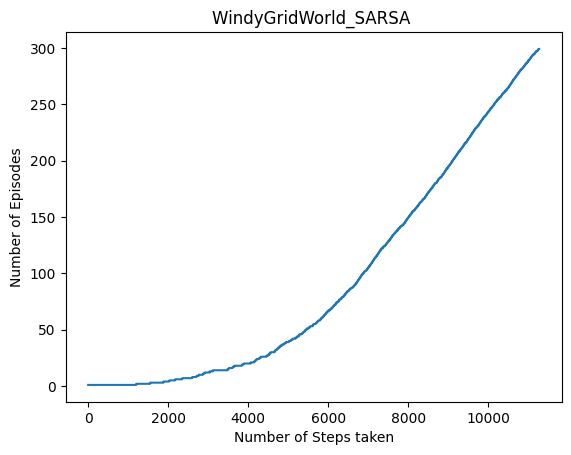

In [13]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.1,α=0.5 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.5, epsilon=0.1)

#### Observation: We observed that it took 19 steps to reach GOAL state for SARSA with ∈=0.1,α=0.5 option. Discounted factor gamma is set as 1.

# 3.2 Experiment Observations for SARSA, ∈=0.2,α=0.1

Plot for Option: ∈=0.2,α=0.1 

[[ 0.  0.  0.  0.  0.  0. 13. 14. 15. 16.]
 [ 0.  0.  0.  0.  0. 12.  0.  0.  0. 17.]
 [ 0.  0.  0.  0. 11.  0.  0.  0.  0. 18.]
 [ 1.  0.  0.  0.  0.  0.  0. 26.  0. 19.]
 [ 2.  0.  0.  0.  9.  0.  0.  0.  0. 20.]
 [ 3.  0.  0.  8.  0.  0.  0.  0. 25. 23.]
 [ 5.  6.  7.  0.  0.  0.  0.  0.  0. 24.]]


Time elapsed is (in Secs):  0.010151386260986328


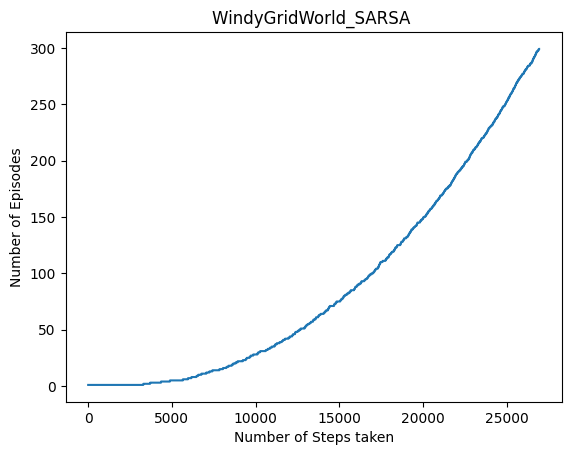

In [14]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.2,α=0.1 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.1, epsilon=0.2)

#### Observation: We observed that it took 25 steps to reach GOAL state for SARSA with ∈=0.1,α=0.5 option. Discounted factor gamma is set as 1.

# 3.3 Experiment Observations for SARSA, ∈=0.05,α=0.2

Plot for Option: ∈=0.05,α=0.2 

[[ 0.  0.  0.  0.  0.  6.  7.  9. 10. 11.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 12.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 14.]
 [ 1.  2.  3.  0.  0.  0.  0. 20.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 19. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]]


Time elapsed is (in Secs):  0.009267568588256836


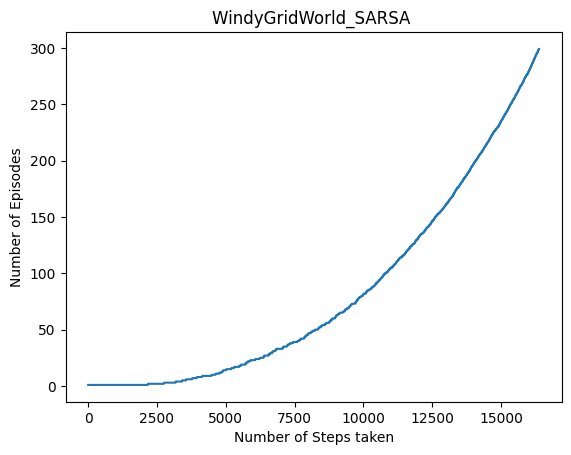

In [15]:
if __name__ == '__main__':
    startState = (3, 0)
    goalState = (3, 7)
    world = gridWorld()
    print("Plot for Option: ∈=0.05,α=0.2 \n")
    gridWorld_SARSA(world, startState, goalState, alpha=0.2, epsilon=0.05)

#### We observed that it took 18 steps to reach GOAL state for SARSA with ∈=0.05,α=0.2 option. Discounted factor gamma is set as 1.

#### We will also see what is the minimum number of episode that the SARSA algorithm is able to learn.

# 4. Q-Learning Algorithm

#### Let us consider Q-learning algorithm. We have considered 300 episodes.

#### Here also we will consider 3 different variations.

* Epsilon = 0.1, Alpha = 0.5
* Epsilon = 0.2, Alpha = 0.1
* Epsilon = 0.05, Alpha = 0.2

In [16]:
def gridWorld_QLearning(world, startState, goalState, alpha, gamma=1, ep_max=300, eps=0.1):
    world.setTerminal(startState, goalState) 
    # Initialize Q(s, a)
    q_dict = {}
    for state in range(world.row * world.col):
        q_dict[state] = {}
        for act in world.actions_list:
            if world.checkTerminal(state):
                q_dict[state][act] = 0
            else:
                q_dict[state][act] = np.random.rand()

    def greedyAct(_q_dict):
        greedy_act = ''
        max_q = -1e10
        for act in world.actions_list:
            if _q_dict[act] > max_q:
                greedy_act = act
                max_q = _q_dict[act]
        return greedy_act

    def epsGreedy(episode, q_dict):
        m = len(world.actions_list)
        greedy_act = greedyAct(q_dict)
        p = []
        for act in world.actions_list:
            if act == greedy_act:
                p.append((eps * 1. / m) + 1 - eps)
            else:
                p.append(eps * 1. / m)
        choice = np.random.choice(world.actions_list, size=1, p=p)
        return choice[0]

    ep_wrt_step = []
    trajectory = []
    for ep in range(1, ep_max + 1):
        s = world.start
        trajectory = []
        while not world.checkTerminal(s):
            # Choose act according to behaviour policy
            act = epsGreedy(ep, q_dict[s])
            # take act, observe s_prime & reward
            s_prime = world.nextState(s, act)
            reward = world.rewardFunction(s_prime)

            # choose act_prime according to target policy
            act_prime = greedyAct(q_dict[s_prime])
            # Update Q(s, a)
            q_dict[s][act] += alpha * (reward + gamma * q_dict[s_prime][act_prime] - q_dict[s][act])

            # store trajectory
            trajectory.append(s)

            # update current state
            s = s_prime
            # store the index of this episode for plot
            ep_wrt_step.append(ep)
        trajectory.append(world.goal)
    return trajectory, ep_wrt_step

# 4.1 Experiment Observations for Q-learning, ∈=0.1,α=0.5

Time elapsed:  0.27241945266723633
[[ 0.  0.  0.  0.  0.  6.  7.  9. 10. 11.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 12.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 13.]
 [ 1.  2.  3.  0.  0.  0.  0. 19.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 18. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 17.]]




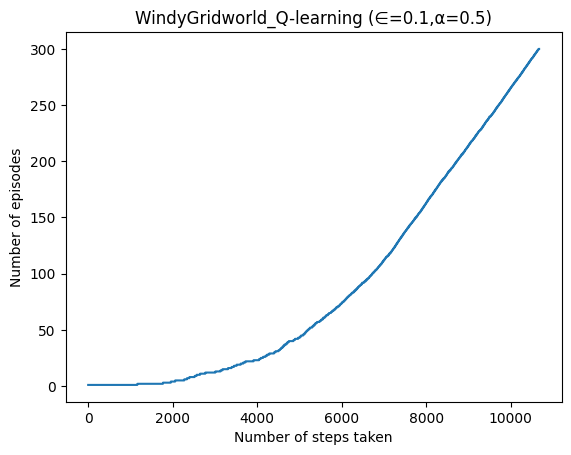

In [17]:
if __name__ == '__main__':
    _start = (3, 0)
    _goal = (3, 7)
    world = gridWorld()
    start_time = time.time()
    trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.5,gamma=0.9,ep_max=300, eps=0.1)
    print("Time elapsed: ", time.time() - start_time)
    trajectoryPath(world, trajectory)
    pl.figure(1)
    pl.plot(ep_wrt_step)
    plt.title('WindyGridworld_Q-learning (∈=0.1,α=0.5)', fontsize = 'large')
    pl.xlabel("Number of steps taken")
    pl.ylabel("Number of episodes")
    pl.show()

#### Observation: We observed that it took 18 steps to reach GOAL state for Q-learning with ∈=0.1,α=0.5 option. Discounted factor gamma is set as 1.

# 4.2 Experiment Observations for Q-learning, ∈=0.2,α=0.1

Time elapsed:  0.6206033229827881
[[ 0.  0.  0. 19. 20. 23. 24. 25. 26. 27.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 28.]
 [ 0.  0.  0. 18.  0.  0.  0.  0.  0. 29.]
 [ 2.  0. 17. 16.  0.  0.  0. 42.  0. 30.]
 [ 8.  9.  0.  0. 15.  0.  0.  0. 34. 35.]
 [ 7. 10. 11. 14.  0.  0.  0.  0. 41. 39.]
 [ 0.  0. 12.  0.  0.  0.  0.  0.  0. 40.]]




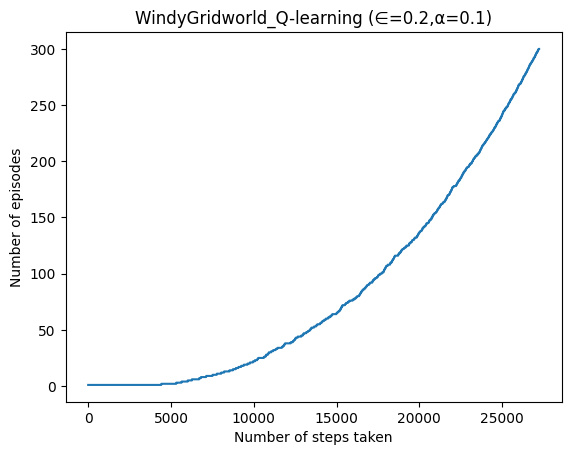

In [18]:
if __name__ == '__main__':
    _start = (3, 0)
    _goal = (3, 7)
    world = gridWorld()
    start_time = time.time()
    trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.1,gamma=0.9,ep_max=300, eps=0.2)
    print("Time elapsed: ", time.time() - start_time)
    trajectoryPath(world, trajectory)
    pl.figure(1)
    pl.plot(ep_wrt_step)
    plt.title('WindyGridworld_Q-learning (∈=0.2,α=0.1)', fontsize = 'large')
    pl.xlabel("Number of steps taken")
    pl.ylabel("Number of episodes")
    pl.show()

#### We observed that it took around 26 steps to reach GOAL state for Q-learning with ∈=0.2,α=0.1 option. Discounted factor gamma is set as 1.

#### Now, we will try to experiment the next option.

# 4.3 Experiment Observations for Q-learning, ∈=0.05,α=0.2

Time elapsed:  0.40517616271972656
[[ 0.  0.  0.  0.  0.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  0.  0.  0.  0. 18.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]]




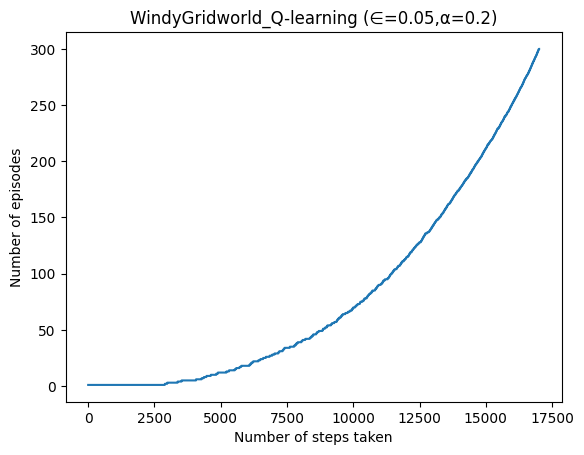

In [19]:
if __name__ == '__main__':
    _start = (3, 0)
    _goal = (3, 7)
    world = gridWorld()
    start_time = time.time()
    trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.2,gamma=0.9,ep_max=300, eps=0.05)
    print("Time elapsed: ", time.time() - start_time)
    trajectoryPath(world, trajectory)
    pl.figure(1)
    pl.plot(ep_wrt_step)
    plt.title('WindyGridworld_Q-learning (∈=0.05,α=0.2)', fontsize = 'large')
    pl.xlabel("Number of steps taken")
    pl.ylabel("Number of episodes")
    pl.show()

#### Observation: We observed that it took 18 steps to reach GOAL state for Q-learning with ∈=0.05,α=0.2 option. Discounted factor gamma is set as 1.

# 5. Summary of Interpretation

So we have experimented both SARSA and Q-learning algorithms for 300 episodes and drawn plots for each of the 3 options of ∈ and α. We summarize the following:

- 3a) SARSA, 300 episodes, ∈=0.1, α=0.5 => we observed 19 minimum steps taken to reach goal state
- 3b) SARSA, 300 episodes, ∈=0.2, α=0.1 => we observed 25 minimum steps taken to reach goal state
- 3c) SARSA, 300 episodes, ∈=0.05, α=0.2 => we observed 18 minimum steps taken to reach goal state


- 4a) Q-learning, 300 episodes, ∈=0.1, α=0.5 => we observed 18 minimum steps taken to reach goal state
- 4b) Q-learning, 300 episodes, ∈=0.2, α=0.1 => we observed 28 minimum steps taken to reach goal state
- 4c) Q-learning, 300 episodes, ∈=0.05, α=0.2 => we observed 19 minimum steps taken to reach goal state

We have plotted charts for "Number of Episodes" vs "Number of Steps taken" for each of the above experiments.

We have observed that initially both algorithms learn in a similar fashion for few episodes. After 25-30 episodes, Q-learning started learning better and quickly compared to SARSA for ∈=0.1, α=0.5

We have also reported minimum length episode that each algorithm / and it's experiments have taken to learn.

In [21]:
from IPython.display import Image
# Image("../input/windygridworld2/WindyGridworld_SARSAvsQlearning.png")